In [1]:
from initial_cleaning import initial_cleaning

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.mlab import PCA as mlabPCA

import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn import neighbors
import datetime
from matplotlib.mlab import PCA as mlabPCA
from sklearn.decomposition import PCA 

%matplotlib inline
sns.set_style('white')
pd.options.display.float_format = '{:.3f}'.format
plt.rcParams['figure.figsize'] = (20.0, 10.0)

In [2]:
beach = pd.DataFrame(initial_cleaning('/Users/jamilab/Data_Science/Data_Sets/beach-water-quality-automated-sensors-1.csv'))

          Beach Name   Measurement Timestamp  Water Temperature  Turbidity  \
0     Montrose Beach  08/30/2013 08:00:00 AM             20.300      1.180   
1  Ohio Street Beach  05/26/2016 01:00:00 PM             14.400      1.230   
2      Calumet Beach  09/03/2013 04:00:00 PM             23.200      3.630   
3      Calumet Beach  05/28/2014 12:00:00 PM             16.200      1.260   
4     Montrose Beach  05/28/2014 12:00:00 PM             14.400      3.360   

   Transducer Depth  Wave Height  Wave Period  Battery Life  \
0             0.891        0.080        3.000         9.400   
1               nan        0.111        4.000        12.400   
2             1.201        0.174        6.000         9.400   
3             1.514        0.147        4.000        11.700   
4             1.388        0.298        4.000        11.900   

  Measurement Timestamp Label               Measurement ID  
0           8/30/2013 8:00 AM    MontroseBeach201308300800  
1          05/26/2016 1:00 PM 

In [3]:
beach = beach.dropna()

In [4]:
beach.isnull().sum()

Beach Name                     0
Measurement Timestamp          0
Water Temperature              0
Turbidity                      0
Transducer Depth               0
Wave Height                    0
Wave Period                    0
Battery Life                   0
Measurement Timestamp Label    0
Measurement ID                 0
dtype: int64

In [5]:
beach_name = pd.get_dummies(beach['Beach Name'])

In [6]:
beach = beach.drop('Beach Name', 1)

In [7]:
beach = pd.concat([beach, beach_name], axis = 1)

In [8]:
beach['Measurement Timestamp'] = pd.to_datetime(beach['Measurement Timestamp'])

In [9]:
beach['Measurement Timestamp Label'] = pd.to_datetime(beach['Measurement Timestamp Label'])

In [10]:
# Define the training and test sizes.

trainsize = int(beach.shape[0] / 2)
beach_test = beach.iloc[trainsize:, :].copy()
beach_train = beach.iloc[:trainsize, :].copy()

Y_train = beach_train['Wave Height'].values.reshape(-1, 1)
X_train = beach_train.drop(['Wave Height', 'Measurement ID', 'Measurement Timestamp', 'Measurement Timestamp Label'], 1)

Y_test = beach_test['Wave Height'].values.reshape(-1, 1)
X_test = beach_test.drop(['Wave Height', 'Measurement ID', 'Measurement Timestamp', 'Measurement Timestamp Label'], 1)

# instantiate linear regression model to predict wave height using all other variables as features & run cross val

regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)

print('\nR-squared raw data:')
print(regr.score(X_test, Y_test))

cross_val_score(regr, X_test, Y_test, cv=10)


R-squared raw data:
-53.6564795875


array([-0.19416026, -2.21994254,  0.44062658,  0.39250194, -0.85739243,
        0.11344895, -0.66506804,  0.46880472, -1.04587309, -0.23056396])

In [11]:
# instantiate & run regression tree with 10 fold cross validation

rfr = ensemble.RandomForestRegressor()
rfr.fit(X_train, Y_train)

print('\nR-squared raw data:')
print(rfr.score(X_test, Y_test))

cross_val_score(rfr, X_test, Y_test, cv=10)


R-squared raw data:
0.118454946501


/Users/jamilab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/Users/jamilab/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jamilab/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jamilab/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A colum

array([-0.17047836, -0.49210191,  0.78673555,  0.43924967, -2.18764044,
        0.60241273,  0.41592751,  0.32601309,  0.02730552,  0.35448695])

In [12]:
# instantiate & run ridge regression model with 10-fold cross validation

ridgeregr = linear_model.Ridge(alpha=10, fit_intercept=False) 
ridgeregr.fit(X_train, Y_train)

print('\nR-squared raw data:')
print(ridgeregr.score(X_test, Y_test))
origparams = ridgeregr.coef_[0]
print(origparams)

cross_val_score(ridgeregr, X_test, Y_test, cv=10)


R-squared raw data:
-53.3500227858
[-0.00039906  0.01026213  0.10031407 -0.00703535  0.00273133 -0.01582579
 -0.0358179  -0.00106737 -0.04219105  0.01361396 -0.00080368]


array([ -1.54041130e-04,  -7.45279552e-01,   3.00828344e-01,
         2.37234483e-01,  -6.02126453e-01,   1.08684971e-01,
        -1.00498815e+00,   3.59648019e-01,  -8.62403641e-01,
        -6.57046511e-01])

In [13]:
# Set up the ridge regression model to predict wave height using all other variables as features.
# Store estimates.

estimates = np.append(ridgeregr.coef_, [10])

# Storing legend information.
labels = []

# Run the model for many alphas

for lambd in range(0, 250, 5):
    ridgeregr = linear_model.Ridge(alpha=lambd, fit_intercept=False)
    ridgeregr.fit(X_train, Y_train)
    estimates = np.row_stack((
        estimates,
        np.append(ridgeregr.coef_,[lambd])))
    print(ridgeregr.coef_,[lambd])
    print('\nR-squared raw data:')
    print(ridgeregr.score(X_test, Y_test))
    
# Make the data pretty

estimates_df = pd.DataFrame(
    estimates,
    columns=list(X_test.columns) + ['lambda'])
estimates_df.sort_values(by='lambda', inplace=True, ascending=True)

[[ 0.00077698  0.01028023  0.14267862 -0.00643512  0.00933884 -0.18812541
  -0.19509401 -0.16349933 -0.21118607 -0.14059703 -0.16223462]] [0]

R-squared raw data:
-53.6564795875
[[-0.00050248  0.01024642  0.10938639 -0.00704573  0.0028721  -0.03121205
  -0.04855562 -0.01493837 -0.05726905  0.00212312 -0.01418212]] [5]

R-squared raw data:
-53.1862351361
[[-0.00039906  0.01026213  0.10031407 -0.00703535  0.00273133 -0.01582579
  -0.0358179  -0.00106737 -0.04219105  0.01361396 -0.00080368]] [10]

R-squared raw data:
-53.3500227858
[[-0.00023906  0.01027826  0.09357402 -0.00699208  0.00293614 -0.00958152
  -0.03147224  0.00419656 -0.03605659  0.01696713  0.00402904]] [15]

R-squared raw data:
-53.5242847595
[[ -8.10462614e-05   1.02929425e-02   8.79584979e-02  -6.94328637e-03
    3.20659622e-03  -6.02725113e-03  -2.94534006e-02   6.98107045e-03
   -3.25400539e-02   1.81192736e-02   6.43482834e-03]] [20]

R-squared raw data:
-53.6844605609
[[  6.48123454e-05   1.03060248e-02   8.31043041e-

In [14]:
# ridge regression 10 fold cross validation

cross_val_score(ridgeregr, X_test, Y_test, cv=10)

array([  6.96686559e-04,  -9.57595555e-01,   7.15310170e-02,
         6.22942787e-02,  -6.10037709e-01,   4.52415847e-02,
        -1.23043378e+00,   1.59855003e-01,  -5.38809566e-01,
        -8.70261823e-02])

In [15]:
# Create interactions to capture potential relationships between features

beach_train['water_turbidity'] = beach_train['Water Temperature'] * beach_train['Turbidity']
beach_train['water_transd_depth'] = beach_train['Water Temperature'] * beach_train['Transducer Depth']
beach_train['water_wave_period'] = beach_train['Water Temperature'] * beach_train['Wave Period']
beach_train['turbidity_transd_depth'] = beach_train['Turbidity']  * beach_train['Transducer Depth']
beach_train['turbidity_wave_period'] = beach_train['Turbidity'] * beach_train['Wave Period']
beach_train['trans_depth_wave_period'] = beach_train['Transducer Depth'] * beach_train['Wave Period']

beach_test['water_turbidity'] = beach_test['Water Temperature'] * beach_test['Turbidity']
beach_test['water_transd_depth'] = beach_test['Water Temperature'] * beach_test['Transducer Depth']
beach_test['water_wave_period'] = beach_test['Water Temperature'] * beach_test['Wave Period']
beach_test['turbidity_transd_depth'] = beach_test['Turbidity']  * beach_test['Transducer Depth']
beach_test['turbidity_wave_period'] = beach_test['Turbidity'] * beach_test['Wave Period']
beach_test['trans_depth_wave_period'] = beach_test['Transducer Depth'] * beach_test['Wave Period']

X_train2 = beach_train.drop(['Wave Height', 'Measurement ID', 'Measurement Timestamp', 'Measurement Timestamp Label'], 1)
X_test2 = beach_test.drop(['Wave Height', 'Measurement ID', 'Measurement Timestamp', 'Measurement Timestamp Label'], 1)


In [16]:
# Build knn regression model

knn = neighbors.KNeighborsRegressor(n_neighbors=10)
X = X_test2
Y = Y_test
knn.fit(X, Y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='uniform')

In [17]:
# Run the model again with weights

knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
knn_w.fit(X, Y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='distance')

In [18]:
# knn cross validation for unweighted & weighted models

score = cross_val_score(knn, X_test2, Y_test, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

score_w = cross_val_score(knn_w, X_test2, Y_test, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: -0.56 (+/- 1.98)
Weighted Accuracy: -0.55 (+/- 1.82)


In [19]:
# instantiate & run ridge regression for feature engineered data with 10 fold cross validation

ridgeregrBig = linear_model.Ridge(alpha=250, fit_intercept=False)
ridgeregrBig.fit(X_train2, Y_train)

print('\nR-squared feature engineered data:')
print(ridgeregrBig.score(X_test2, Y_test))

cross_val_score(ridgeregrBig, X_test2, Y_test, cv=10)


R-squared feature engineered data:
-244.034288331


array([  0.10571767,  -0.96580841,   0.40549043,   0.44561939,
        -0.38427139,   0.05343661, -17.04847175,   0.26731441,
        -0.4528973 ,  -0.05122396])

In [20]:
# Run the model for many alphas. Store parameter estimates

estimatesBig = np.append(ridgeregrBig.coef_, [10])

# Store legend information

labels = []

for lambd in range(0, 250, 5):
    ridgeregrBig = linear_model.Ridge(alpha=lambd, fit_intercept=False)
    ridgeregrBig.fit(X_train2, Y_train)
    estimatesBig = np.row_stack((
        estimatesBig,
        np.append(ridgeregrBig.coef_,[lambd])))
    print(ridgeregrBig.coef_,[lambd])
    print('\nR-squared complex model:')
    print(ridgeregrBig.score(X_test2, Y_test))

[[-0.01798832 -0.03852849  0.0769786  -0.02883292  0.00983055  0.08872109
   0.08206302  0.11523478  0.06250032  0.13458427  0.11561704  0.00345396
   0.00588609  0.00142366 -0.01187853  0.00317462 -0.00458147]] [0]

R-squared complex model:
-570.493181287
[[-0.01399507 -0.03310447  0.08577153 -0.01732013  0.01167553 -0.00210344
  -0.0098378   0.0248193  -0.0275688   0.04274047  0.02462935  0.00323863
   0.00530441  0.00081112 -0.01279119  0.00304993 -0.00470153]] [5]

R-squared complex model:
-514.174192593
[[-0.01412052 -0.03044316  0.06604314 -0.01277878  0.01243815 -0.00405984
  -0.0126305   0.02261946 -0.02916037  0.03923043  0.02207004  0.00312
   0.00624067  0.00057098 -0.01311346  0.00299456 -0.00473432]] [10]

R-squared complex model:
-486.500951898
[[-0.01413894 -0.02829388  0.05366081 -0.01007599  0.01287966 -0.00499271
  -0.01416454  0.02140608 -0.02979847  0.03709224  0.02062383  0.00302556
   0.00679664  0.00042224 -0.01340575  0.00295607 -0.00467621]] [15]

R-squared com

[[-0.01049114 -0.00930668  0.00685161 -0.00143617  0.01301072 -0.00339941
  -0.01789545  0.01467208 -0.0233921   0.02113579  0.01223892  0.00190202
   0.00707867 -0.00024332 -0.01311226  0.00259971 -0.00187472]] [205]

R-squared complex model:
-260.51727298
[[-0.010419   -0.00916342  0.00670935 -0.00140436  0.01298674 -0.0033287
  -0.01785563  0.0145981  -0.02323019  0.02095115  0.0121499   0.00188721
   0.00704937 -0.00024791 -0.01304178  0.00259492 -0.00183318]] [210]

R-squared complex model:
-258.504222989
[[-0.01034803 -0.00902481  0.00657358 -0.00137343  0.01296299 -0.00325947
  -0.017815    0.01452519 -0.02307056  0.02077031  0.0120625   0.00187267
   0.00702036 -0.00025239 -0.01297129  0.0025902  -0.00179246]] [215]

R-squared complex model:
-256.541239052
[[-0.01027821 -0.00889061  0.00644388 -0.00134332  0.01293947 -0.0031917
  -0.01777364  0.01445331 -0.02291317  0.02059312  0.01197666  0.00185839
   0.00699165 -0.00025676 -0.01290085  0.00258556 -0.00175253]] [220]

R-squar

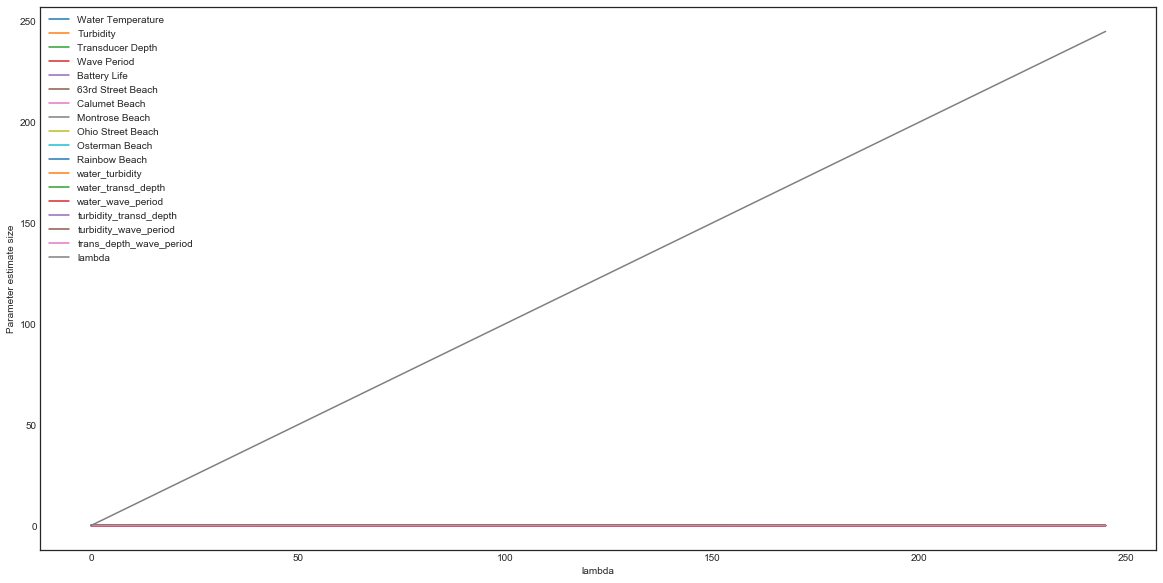

In [21]:
# Make the data pretty

estimates_df = pd.DataFrame(
    estimatesBig,
    columns=list(X_test2.columns) + ['lambda'])
estimates_df.sort_values(by='lambda', inplace=True, ascending=True)

varstoplot = list(estimates_df.columns)
varstoplot

# Plot a line for each parameter

for var in varstoplot:
    plt.plot(estimates_df['lambda'], estimates_df[var])
    labels.append(var)
plt.xlabel('lambda')
plt.ylabel('Parameter estimate size')
plt.legend(labels)
plt.show()

In [22]:
# create a dataframe to hold features

features = pd.concat([beach.copy()], axis = 1)

In [23]:
# create interactions

features['temp_turbidity'] = features['Water Temperature'] * features['Turbidity']
features['temp_transd_depth'] = features['Water Temperature'] * features['Transducer Depth']
features['temp_wave_period'] = features['Water Temperature'] * features['Wave Period']
features['turbidity_transd_depth'] = features['Turbidity']  * features['Transducer Depth']
features['turbidity_wave_period'] = features['Turbidity'] * features['Wave Period']
features['trans_depth_wave_period'] = features['Transducer Depth'] * features['Wave Period']

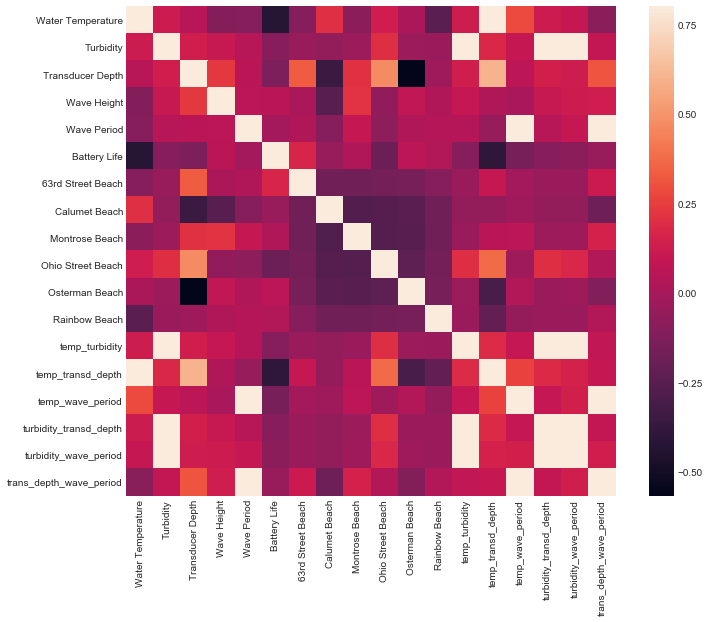

In [24]:
# view a correlation matrix to determine collinearity, if any

corrmat = features.corr()

# Set up the matplotlib figure.

f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn

sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

In [25]:
means = features[['Turbidity', 'turbidity_transd_depth', 'turbidity_wave_period', 'temp_wave_period']].mean(axis=0)
stds = features[['Turbidity', 'turbidity_transd_depth', 'turbidity_wave_period', 'temp_wave_period']].std(axis=0)
features['transd_wave_turbid'] = ((features[['Turbidity', 'turbidity_transd_depth', 'turbidity_wave_period', 
                                             'temp_wave_period']] - means) / stds).mean(axis=1)

# Check how well the composite correlates with each individual variable

plotdf = features.loc[:, ['Turbidity', 'turbidity_transd_depth', 'turbidity_wave_period', 'temp_wave_period']]
plotdf['transd_wave_turbid'] = features['transd_wave_turbid'] 
corrmat2 = plotdf.corr()

print(corrmat2)

                        Turbidity  turbidity_transd_depth  \
Turbidity                   1.000                   1.000   
turbidity_transd_depth      1.000                   1.000   
turbidity_wave_period       0.935                   0.934   
temp_wave_period            0.095                   0.094   
transd_wave_turbid          0.940                   0.939   

                        turbidity_wave_period  temp_wave_period  \
Turbidity                               0.935             0.095   
turbidity_transd_depth                  0.934             0.094   
turbidity_wave_period                   1.000             0.139   
temp_wave_period                        0.139             1.000   
transd_wave_turbid                      0.933             0.412   

                        transd_wave_turbid  
Turbidity                            0.940  
turbidity_transd_depth               0.939  
turbidity_wave_period                0.933  
temp_wave_period                     0.412  
trans

In [26]:
# change 0ºC to .001º to avoid 0 division error 

beach['Water Temperature'] = beach['Water Temperature'].replace(0, 0.001, regex=True)

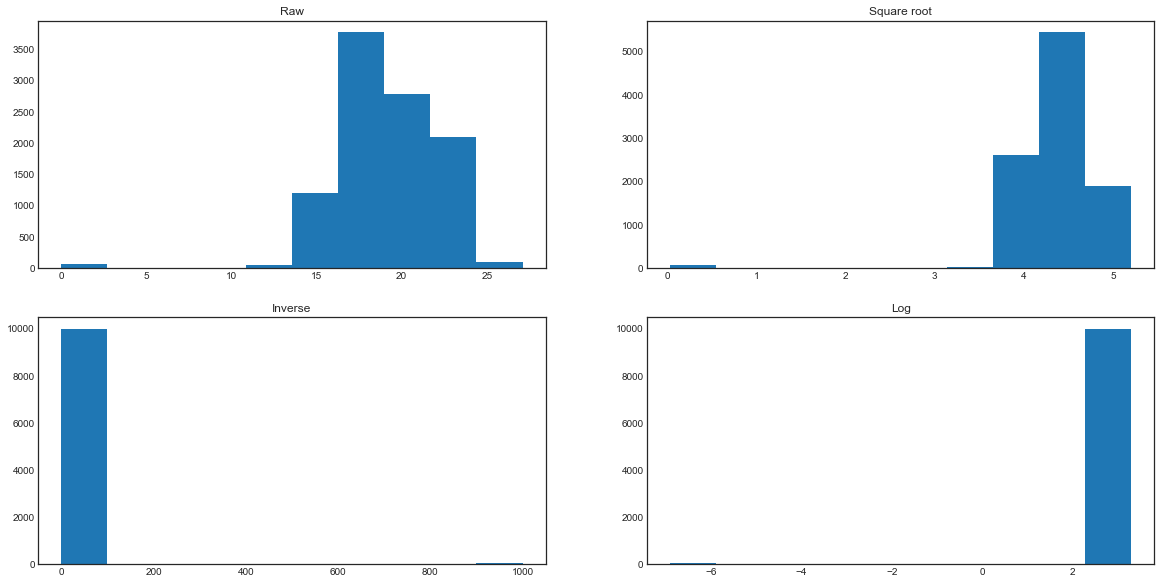

In [27]:
# Using water temperature since it's less highly correlated to the other features to create a transformation one.
# Four-panel plot

fig = plt.figure()

fig.add_subplot(221)
plt.hist(beach['Water Temperature'])
plt.title('Raw')

fig.add_subplot(222)
plt.hist(np.sqrt(beach['Water Temperature']))
plt.title('Square root')

fig.add_subplot(223)
plt.hist(1/beach['Water Temperature'])
plt.title('Inverse')

ax3=fig.add_subplot(224)
plt.hist(np.log(beach['Water Temperature']))
plt.title('Log')
plt.show()

# Create a transformation using square root, since it's the most approximately normal of the 3

features['sqrt_temp'] = (np.sqrt(beach['Water Temperature']))

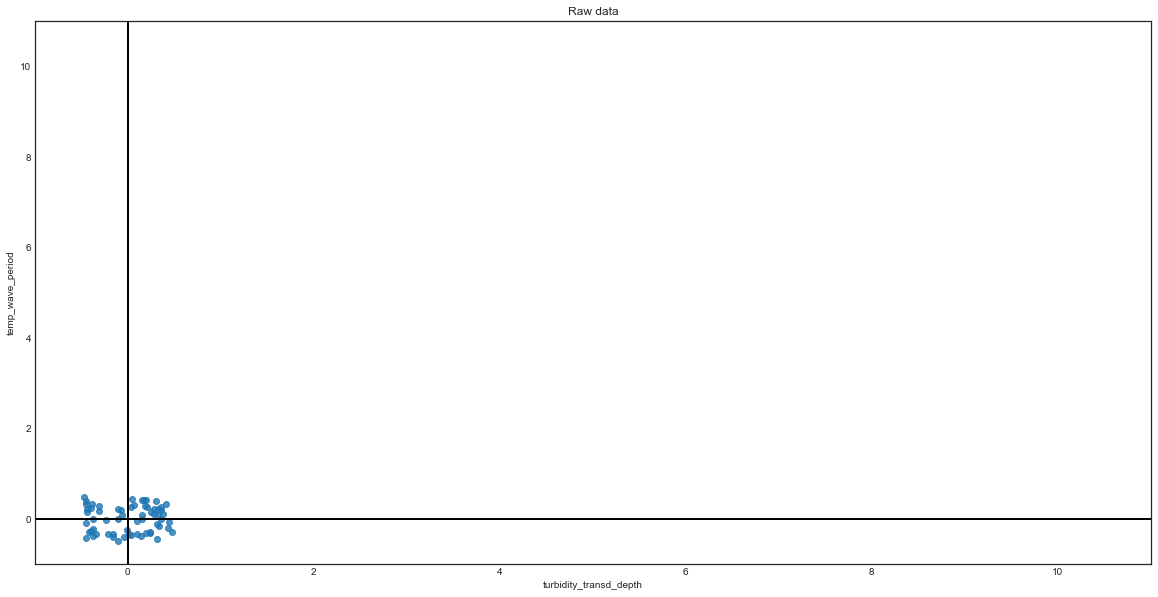

/Users/jamilab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jamilab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


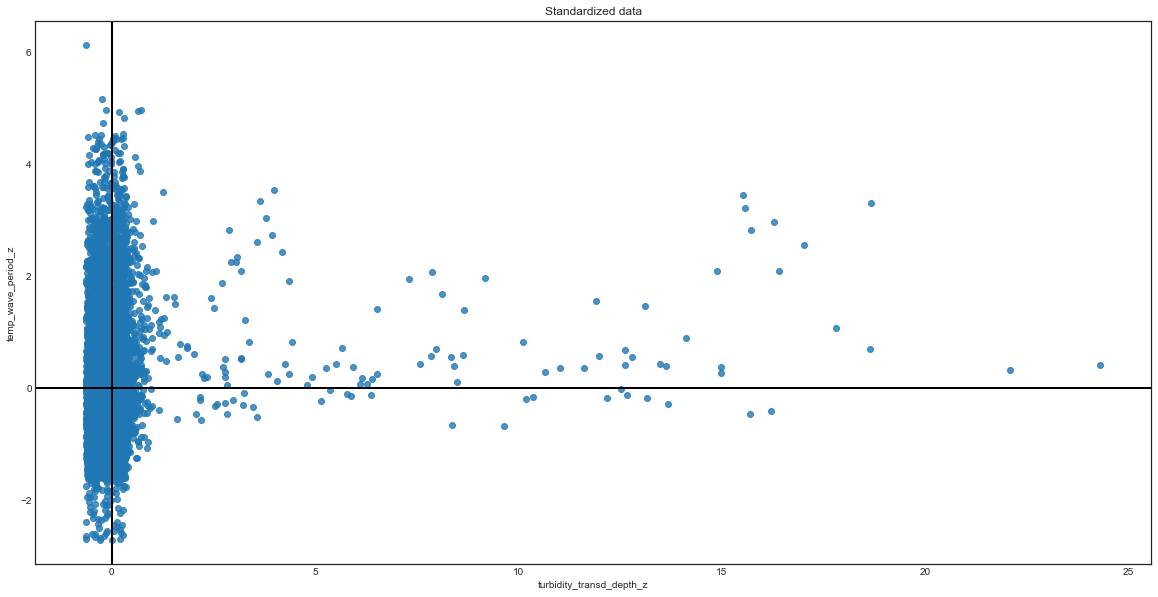

In [28]:
# Make the scatterplot matrix. Take a subset of the data for PCA. 

df_pca = features[['Turbidity', 'turbidity_transd_depth', 'turbidity_wave_period', 'temp_wave_period']]

t = sns.regplot(
    'turbidity_transd_depth',
    'temp_wave_period',
    df_pca,
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
t.set(xlim=(-1, 11), ylim=(-1, 11))
t.axhline(0, color='k', linestyle='-', linewidth=2)
t.axvline(0, color='k', linestyle='-', linewidth=2)
t.axes.set_title('Raw data')
plt.show()

# Standardizing variables by subtracting the mean and dividing by the standard deviation. 

df_pca['turbidity_transd_depth_z'] = (df_pca['turbidity_transd_depth'] - df_pca['turbidity_transd_depth'].mean()) / df_pca['turbidity_transd_depth'].std()
df_pca['temp_wave_period_z'] = (df_pca['temp_wave_period'] - df_pca['temp_wave_period'].mean()) / df_pca['temp_wave_period'].std()

t = sns.regplot(
    'turbidity_transd_depth_z',
    'temp_wave_period_z',
    df_pca,
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
t.axhline(0, color='k', linestyle='-', linewidth=2)
t.axvline(0, color='k', linestyle='-', linewidth=2)
t.axes.set_title('Standardized data')
plt.show()

/Users/jamilab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jamilab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


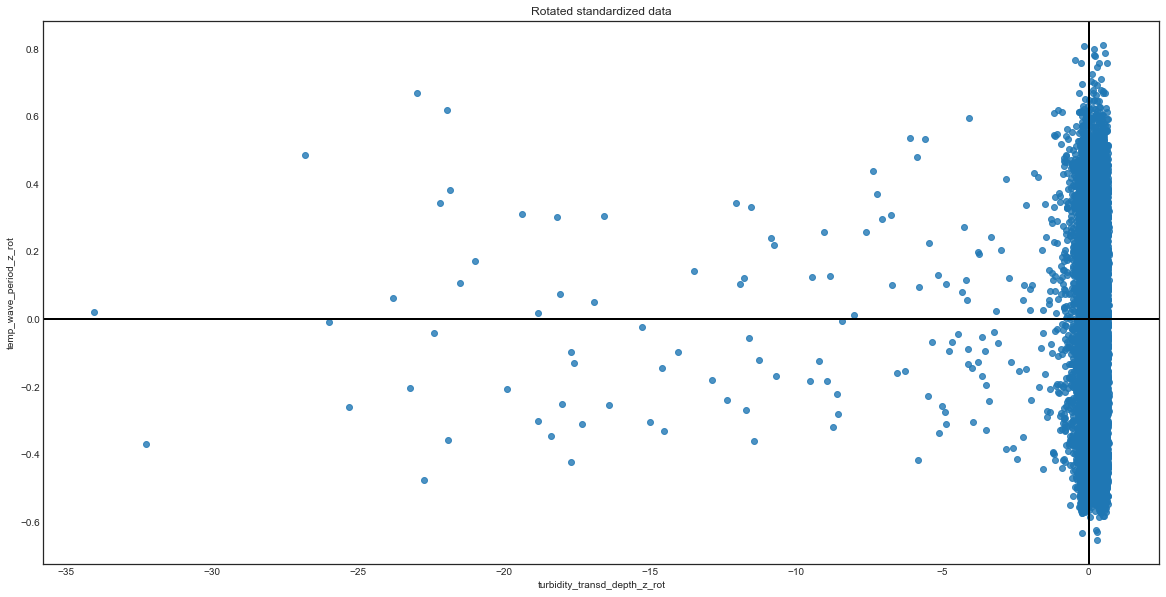

In [29]:
# Rotating the data so that the axes roughly match to vector above

df_pca['turbidity_transd_depth_z_rot'] = math.cos(40) * df_pca['turbidity_transd_depth_z'] - math.sin(40) * df_pca['turbidity_transd_depth_z']
df_pca['temp_wave_period_z_rot'] = math.sin(40) * df_pca['temp_wave_period_z'] + math.cos(40) * df_pca['temp_wave_period_z']

t = sns.regplot(
    'turbidity_transd_depth_z_rot',
    'temp_wave_period_z_rot',
    df_pca,
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
t.axhline(0, color='k', linestyle='-', linewidth=2)
t.axvline(0, color='k', linestyle='-', linewidth=2)
t.axes.set_title('Rotated standardized data')
plt.show()



In [30]:
# Normalize the data so that all variables have a mean of 0 and standard deviation of 1

X = StandardScaler().fit_transform(df_pca)

# NumPy covariance function assumes variables are represented by rows, not columns, so transpose X

Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

Covariance Matrix:
 [[ 1.00009967  0.99971266  0.93508951  0.09547065  0.99971266  0.09547065
  -0.99971266  0.09547065]
 [ 0.99971266  1.00009967  0.93389446  0.09374247  1.00009967  0.09374247
  -1.00009967  0.09374247]
 [ 0.93508951  0.93389446  1.00009967  0.13912459  0.93389446  0.13912459
  -0.93389446  0.13912459]
 [ 0.09547065  0.09374247  0.13912459  1.00009967  0.09374247  1.00009967
  -0.09374247  1.00009967]
 [ 0.99971266  1.00009967  0.93389446  0.09374247  1.00009967  0.09374247
  -1.00009967  0.09374247]
 [ 0.09547065  0.09374247  0.13912459  1.00009967  0.09374247  1.00009967
  -0.09374247  1.00009967]
 [-0.99971266 -1.00009967 -0.93389446 -0.09374247 -1.00009967 -0.09374247
   1.00009967 -0.09374247]
 [ 0.09547065  0.09374247  0.13912459  1.00009967  0.09374247  1.00009967
  -0.09374247  1.00009967]]


In [31]:
# Calculating eigenvalues and eigenvectors

eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspect eigenvalues and eigenvectors

for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].reshape(1, 8).T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[[-0.44137499+0.j]
 [-0.44122220+0.j]
 [-0.42668008+0.j]
 [-0.11416530+0.j]
 [-0.44122220+0.j]
 [-0.11416530+0.j]
 [ 0.44122220+0.j]
 [-0.11416530+0.j]]
Eigenvalue 1: (4.976239375242475+0j)
----------------------------------------
Eigenvector 2: 
[[-0.09412967+0.j]
 [-0.09513361+0.j]
 [-0.06162129+0.j]
 [ 0.56574176+0.j]
 [-0.09513361+0.j]
 [ 0.56574176+0.j]
 [ 0.09513361+0.j]
 [ 0.56574176+0.j]]
Eigenvalue 2: (2.921970277125387+0j)
----------------------------------------
Eigenvector 3: 
[[-0.20651749+0.j]
 [-0.21800379+0.j]
 [ 0.90225623+0.j]
 [-0.01535429+0.j]
 [-0.21800379+0.j]
 [-0.01535429+0.j]
 [ 0.21800379+0.j]
 [-0.01535429+0.j]]
Eigenvalue 3: (0.10201953876083661+0j)
----------------------------------------
Eigenvector 4: 
[[ -8.68146446e-01+0.j]
 [  2.86496515e-01+0.j]
 [  8.97846209e-03+0.j]
 [  3.54266347e-04+0.j]
 [  2.86496515e-01+0.j]
 [  3.54266347e-04+0.j]
 [ -2.86496515e-01+0.j]
 [  3.54266346e-04+0.j]]
Eigenvalue 4: (0.0005681775546431786+0j)
-------

**Component 1 and 2 at 62% & 36% respectively, account for approximately 98% of the variance in the dataset.** 

/Users/jamilab/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


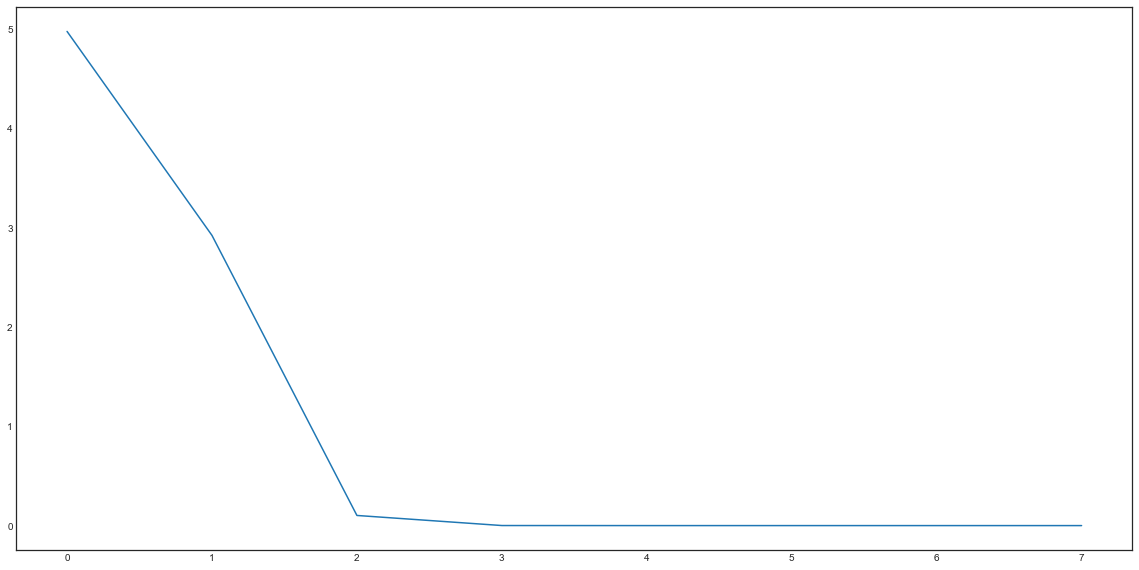

In [32]:
plt.plot(eig_val_cov)
plt.show()

/Users/jamilab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/jamilab/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:583: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


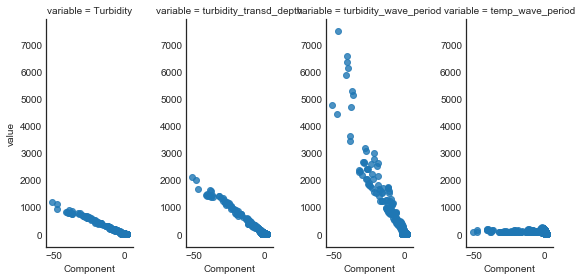

In [33]:
# Create P, which we will use to transform Cx into Cy to get Y, the dimensionally-reduced representation of X.

P = eig_vec_cov[:, 0]

# Transform X into Y

Y = P.T.dot(Xt)

# Combine X and Y for plotting purposes.

data_to_plot = df_pca[['Turbidity', 'turbidity_transd_depth', 'turbidity_wave_period', 'temp_wave_period']]
data_to_plot['Component'] = Y
data_to_plot = pd.melt(data_to_plot, id_vars='Component')

g = sns.FacetGrid(data_to_plot, col="variable", size=4, aspect=.5)
g = g.map(
    sns.regplot,
    "Component",
    "value",
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
plt.show()

The percentage of total variance in the dataset explained by each component.
 [  6.21967930e-01   3.65209884e-01   1.27511714e-02   7.10151162e-05]


/Users/jamilab/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


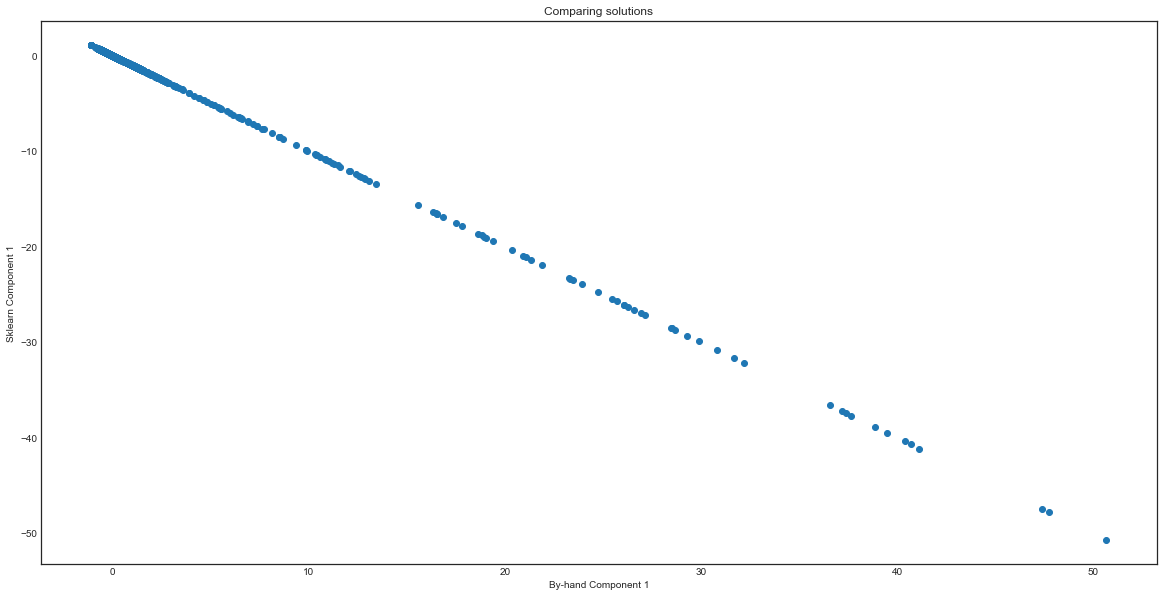

In [34]:
sklearn_pca = PCA(n_components=4)
Y_sklearn = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each component.\n',
    sklearn_pca.explained_variance_ratio_
)

# Compare the sklearn solution to ours – a perfect match.

plt.plot(Y_sklearn[:, 0], Y, 'o')
plt.title('Comparing solutions')
plt.ylabel('Sklearn Component 1')
plt.xlabel('By-hand Component 1')
plt.show()